In [6]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Simple Bandit algorithms

bernoulli bandit is used below

In [304]:
from bandits.bandits import BernoulliBandit
from bandits.agents import EpsilonGreedyAgent, UCB1Agent

In [440]:
np.random.seed(2)
# probs = [0.2, 0.8]
N_SIMULATIONS = 100
T = 5000
K = 2

eps = 0.2  # probability of exploration
alpha = 0.1
alpha = 1

In [441]:
np.random.seed(2)
eg_rewards = []
ucb_rewards = []

for n_simulation in tqdm(range(N_SIMULATIONS)):
    probs = np.random.uniform(0.3, 0.7, size=K)
    
    bandit = BernoulliBandit(probs=probs)
    eg_agent = EpsilonGreedyAgent(bandit=bandit, eps=eps)
    for t in range(T):
        eg_agent.take_action()
    eg_rewards.append(eg_agent.reward_history)
    
    ucb_agent = UCB1Agent(bandit=bandit, alpha=alpha)
    for t in range(T):
        ucb_agent.take_action()
    ucb_rewards.append(ucb_agent.reward_history)

  0%|          | 0/100 [00:00<?, ?it/s]

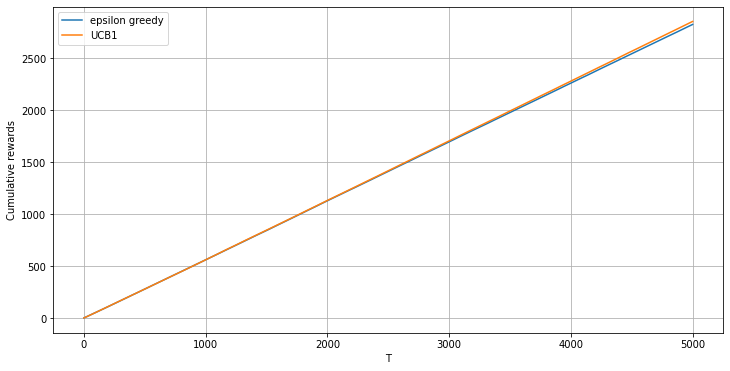

In [442]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
sns.lineplot(x=ts, y=np.cumsum(np.mean(eg_rewards, axis=0)), label='epsilon greedy')
sns.lineplot(x=ts, y=np.cumsum(np.mean(ucb_rewards, axis=0)), label='UCB1')
plt.xlabel('T')
plt.ylabel('Cumulative rewards')
plt.grid();

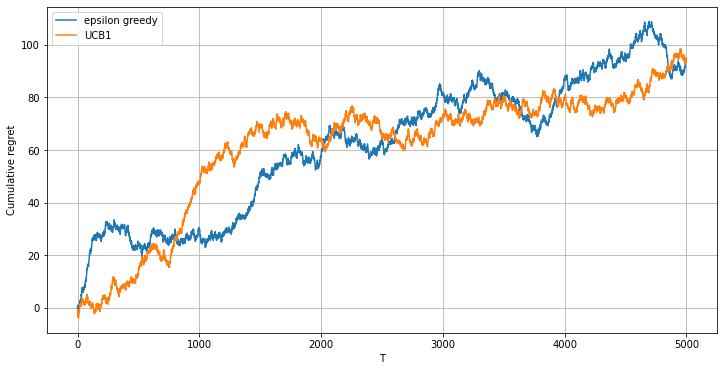

In [443]:
# for a single realisation

fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
best = ts*np.max(probs)
# sns.lineplot(x=ts, y=best, label='best')
sns.lineplot(x=ts, y=best-np.cumsum(eg_agent.reward_history), label='epsilon greedy')
sns.lineplot(x=ts, y=best-np.cumsum(ucb_agent.reward_history), label='UCB1')
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [450]:
ucb_agent._choose_bandit()

1

In [451]:
np.argmax(probs)

1

In [452]:
probs

array([0.36334533, 0.51990159])

In [453]:
(
    eg_agent.bandit_to_mean_rewards,
    ucb_agent.bandit_to_mean_rewards
)

(array([0.3536379 , 0.52075301]), array([0.36893204, 0.51264167]))

In [454]:
(
    eg_agent.bandit_to_num_pulls,
    ucb_agent.bandit_to_num_pulls
)

(array([ 591., 4409.]), array([ 412., 4588.]))

In [455]:
upper = np.sqrt(2 * np.log(ucb_agent.t) / ucb_agent.bandit_to_num_pulls)
upper

array([0.20333617, 0.06093286])

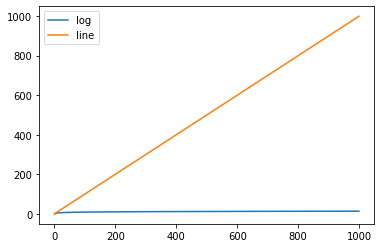

In [458]:
T = 1000
xs = np.arange(1, T)
sns.lineplot(x=xs, y=2*np.log(xs), label='log');
sns.lineplot(x=xs, y=xs, label='line');